### Intro

**What is TF-IDF?**

TF-IDF stands for **Term Frequency-Inverse Document Frequency**. It is a statistical measure used to evaluate how important a word is to a document in a collection of documents or a corpus. This method is extensively utilized in natural language processing (NLP) and information retrieval.

**How Does It Work?**

TF-IDF consists of two parts:

1. **Term Frequency (TF)**: This measures how frequently a word appears in a document. The formula is:
```
TF  = (frequency of the token in the doc) / (total number of tokens in the doc)
```
2. **Inverse Document Frequency (IDF)**: This measures the importance of the word in the corpus. The IDF value decreases if the word is common across multiple documents. The formula is:
```
IDF = 1 + log(total number of docs)/(number of doc containing the token)
```

**Example Application**:
Consider a corpus with three documents:

1. Document 1: "The cat plays with its toy."
2. Document 2: "The dog and cat are friends."
3. Document 3: "The dog loves to run in the park."

To calculate the TF-IDF for the word "cat":

1. **TF for 'cat' in Document 1**:

* Frequency of 'cat': 1
* Total words: 5
* TF = 1/5 = 0.2


2. **IDF for 'cat':**

* Total documents: 3
* Documents with 'cat': 2
* IDF = 1 + log(3/2) ≈ 1.176

3. **TF-IDF for 'cat' in Document 1:**

**TF-IDF = 0.2 * 1.176 ≈ 0,23**



In the next notebooks, I will show how other techniques such as **Word2Vec, Doc2Vec, FastText, BERT, and LLM** can be utilized

# Credit
Fork from https://www.kaggle.com/code/rsuhara/ai-generated-text-detection-quick-baseline

Inspired by VLADIMIR DEMIDOV's work : <br>
https://www.kaggle.com/code/yekenot/llm-detect-by-regression

For the training data we shall use the "RDizzl3 seven" dataset (v1) which can be found in the "LLM: 7 prompt training dataset" https://www.kaggle.com/datasets/carlmcbrideellis/llm-7-prompt-training-dataset


In [22]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:70% !important; }</style>')) 
import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier, DummyRegressor
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/tmp/ipykernel_47/278505135.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [23]:
external_df = pd.read_csv("/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv", sep=',')
print(external_df.shape)
external_df = external_df.rename(columns={'generated': 'label'})
external_df = external_df[["source_text"]]
external_df.columns = ["text"]
external_df['text'] = external_df['text'].str.replace('\n', '')
external_df["label"] = 1

(2421, 4)


In [24]:
train = pd.read_csv("/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v1.csv")
df=pd.concat([train,external_df])

In [25]:
models = [
        ('svm', SVC(probability = True)),
        ('sgd', SGDClassifier(max_iter=5000, tol=1e-3, loss="modified_huber")),
        ('decision tree', DecisionTreeClassifier(max_depth=10)),
        ('ligistic',LogisticRegression(solver="liblinear")),
        ('random forest', RandomForestClassifier(n_estimators=550, max_depth=7, random_state=0)),
        ('xgboost', xgb.XGBClassifier(n_estimators=550, max_depth=5, random_state=0)),
        ('lightgbm', lgb.LGBMClassifier(n_estimators=550, max_depth=5, random_state=0)),
        ('catboost', ctb.CatBoostClassifier(n_estimators=550, max_depth=5, random_state=0, verbose=0))
    ]

def run_models(X, y, scoring = 'binary'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2000)
    
    num_cols = 4
    fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(20,10))
    metrics = {}
    for it, (model_name, model) in enumerate(models):
    
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred, average = scoring).round(3)
        AUC = roc_auc_score(y_test, y_pred_proba[:, 1]).round(3)
        print(f"F1 Score {model_name}: {f1}. AUC: {AUC}")
        metrics[model_name] = AUC
        cm = confusion_matrix(y_test, y_pred)

    # Display confusion matrix values
        print(f"Confusion Matrix for {type(model).__name__}:\n")
        print("True Negative:", cm[0, 0])
        print("False Positive:", cm[0, 1])
        print("False Negative:", cm[1, 0])
        print("True Positive:", cm[1, 1])
        
        ax = axes[it // num_cols, it % num_cols]
        plot_confusion_matrix(y_test, y_pred, ax=ax, title=f"model: {model_name}")
    return metrics

# Meta Features

In [26]:
df['len'] = df['text'].str.len()
df['question'] = df['text'].map(lambda text: 1 if "?" in text else 0)
df['exclamation'] = df['text'].map(lambda text: 1 if "!" in text else 0)
df['n_word'] = df['text'].map(lambda x: len(x.split()))
X  = df[['n_word','question','exclamation','len']]
y = df['label']
y.value_counts()

label
0    14250
1     4042
Name: count, dtype: int64

F1 Score svm: 0.449. AUC: 0.947
Confusion Matrix for SVC:

True Negative: 4238
False Positive: 2
False Negative: 886
True Positive: 362
F1 Score sgd: 0.782. AUC: 0.868
Confusion Matrix for SGDClassifier:

True Negative: 3906
False Positive: 334
False Negative: 232
True Positive: 1016
F1 Score decision tree: 0.771. AUC: 0.923
Confusion Matrix for DecisionTreeClassifier:

True Negative: 4092
False Positive: 148
False Negative: 373
True Positive: 875
F1 Score ligistic: 0.847. AUC: 0.961
Confusion Matrix for LogisticRegression:

True Negative: 4109
False Positive: 131
False Negative: 235
True Positive: 1013
F1 Score random forest: 0.439. AUC: 0.912
Confusion Matrix for RandomForestClassifier:

True Negative: 4229
False Positive: 11
False Negative: 894
True Positive: 354
F1 Score xgboost: 0.839. AUC: 0.959
Confusion Matrix for XGBClassifier:

True Negative: 4103
False Positive: 137
False Negative: 248
True Positive: 1000
F1 Score lightgbm: 0.841. AUC: 0.962
Confusion Matrix for LGBMClassifi

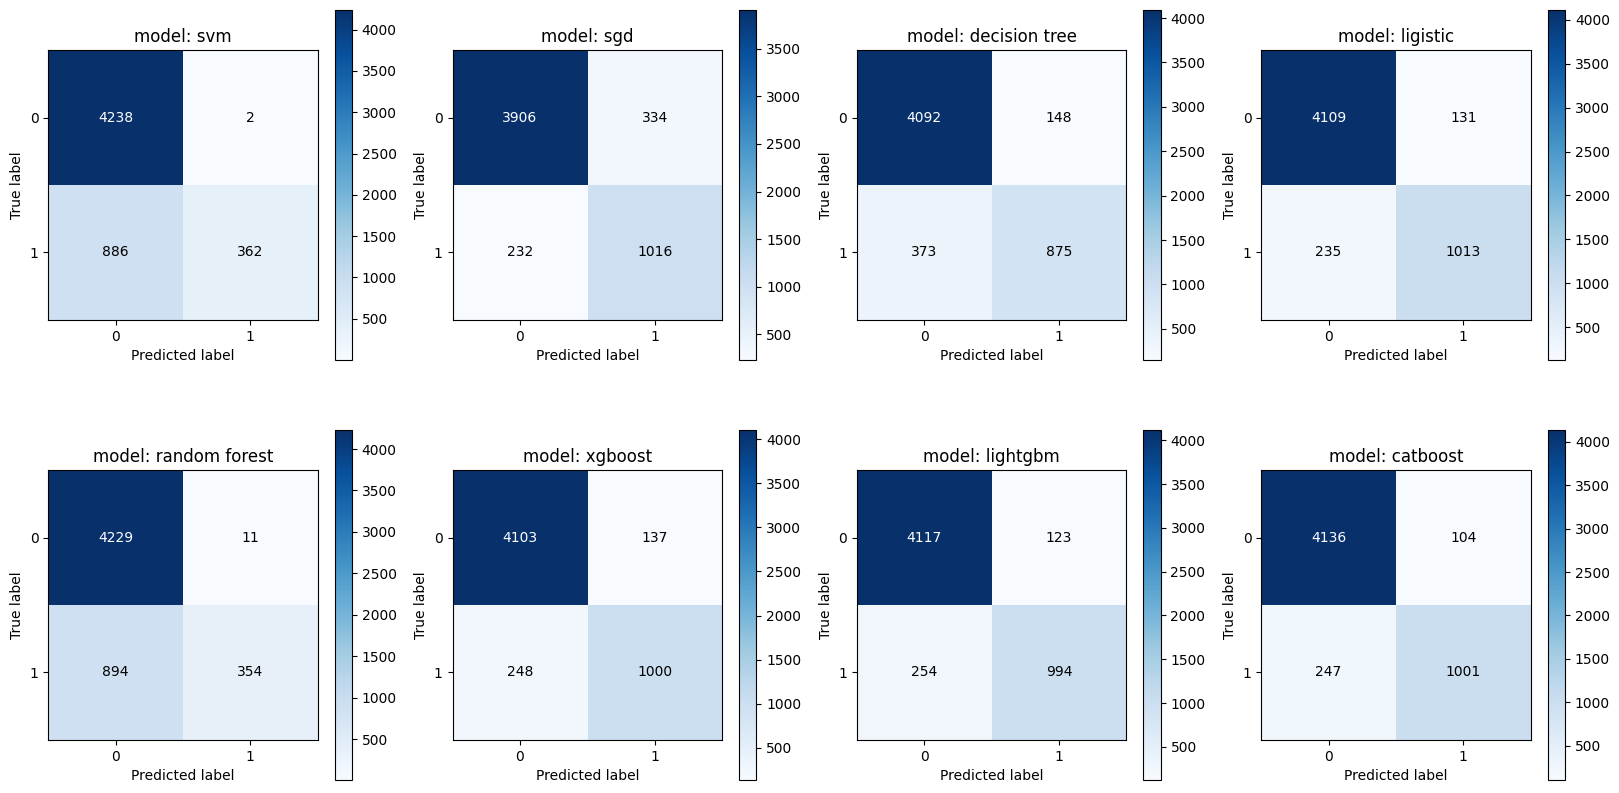

In [27]:
# AUC is quite high even on basics features!
meta_features = run_models(X, y)

### Most important hyperparameters TFIDF technique
1. **Max Features**: This parameter defines the maximum number of most important features (words) to include, based on frequency. It's essential for limiting the feature vector size, especially when dealing with large text corpora.

2. **N-gram Range**: This parameter determines the range of n-gram sizes to consider. N-grams are combinations of adjacent words in the text. For instance, a range of (1, 3) would include unigrams (single words), bigrams (pairs of words), and trigrams (sets of three words).

3. **Min_df** (Minimum Document Frequency): This parameter is used to ignore terms that appear less frequently than a specified threshold. It can be expressed as a percentage (e.g., 0.01, meaning ignoring words that appear in less than 1% of documents) or as an absolute number of documents.

4. **Max_df** (Maximum Document Frequency): Similar to min_df, this parameter is used to ignore terms that are too common. For example, a max_df of 0.85 would mean ignoring terms that appear in more than 85% of documents, as they might be general words not contributing to distinguishing between documents.

5. **Stop Words**: This parameter specifies if and which stop words (e.g., "and", "or", "but") should be ignored. These words are typically excluded as they do not carry significant semantic information for analysis.

Top words:  ['able' 'about' 'accidents' 'according' 'action' 'actually' 'advantages'
 'after' 'against' 'air' 'alien' 'aliens' 'all' 'allow' 'almost' 'alot'
 'already' 'also' 'alternative' 'although' 'always' 'am' 'america'
 'american' 'amount' 'an' 'and' 'animals' 'another' 'any' 'anything' 'are'
 'areas' 'around' 'article' 'as' 'at' 'atmosphere' 'attention' 'author'
 'away' 'back' 'bad' 'ban' 'be' 'because' 'become' 'becoming' 'been'
 'before' 'being' 'believe' 'beneficial' 'benefit' 'benefits' 'best'
 'better' 'between' 'big' 'bogota' 'bored' 'both' 'but' 'by' 'called'
 'campaign' 'can' 'candidate' 'candidates' 'car' 'carbon' 'care' 'cars'
 'cause' 'certain' 'challenge' 'chance' 'change' 'choose' 'cities'
 'citizens' 'city' 'class' 'classroom' 'clear' 'close' 'coding' 'college'
 'come' 'comes' 'communities' 'community' 'computer' 'computers'
 'conclusion' 'conditions' 'confused' 'congestion' 'control' 'could'
 'countries' 'country' 'cowboy' 'cowboys' 'create' 'created' 'dangerous'
 

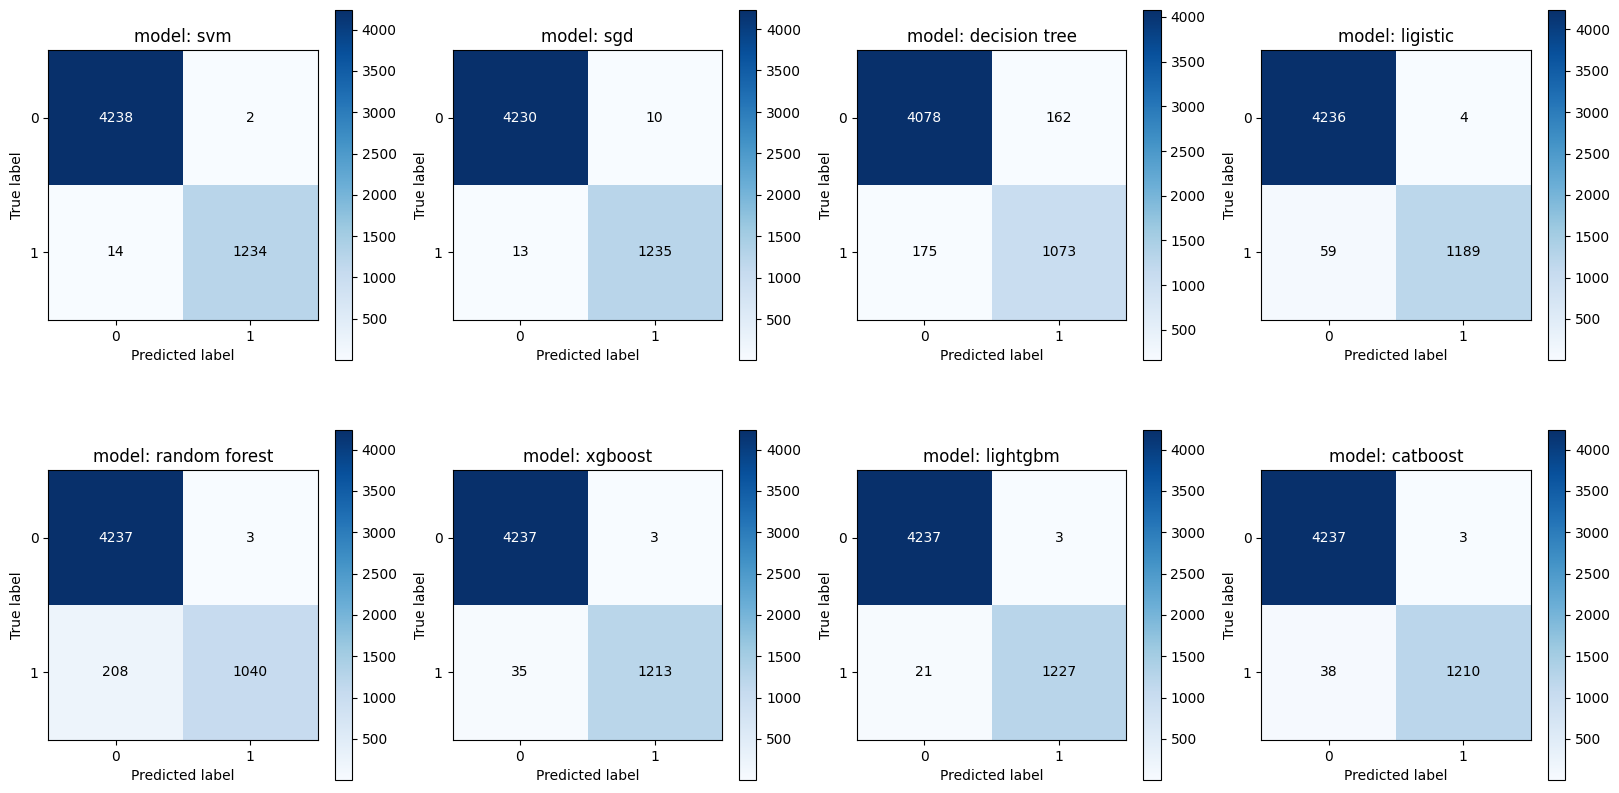

In [28]:
### Lets take 500 most common words
CV = TfidfVectorizer(max_features=500)
X = CV.fit_transform(df['text']).toarray()
print("Top words: ",CV.get_feature_names_out())
feat_500 = run_models(X, y)
# Boosting model seems to be the best

Top words:  ['12' '2000' '2001' '50' '60' 'able' 'accident' 'accidents' 'according'
 'action' 'activities' 'actually' 'additionally' 'advantage' 'advantages'
 'agree' 'air' 'alien' 'aliens' 'allow' 'allows' 'alot' 'alternative'
 'amazing' 'america' 'american' 'americans' 'animals' 'appeal' 'areas'
 'aren' 'argue' 'article' 'atmosphere' 'attention' 'author' 'away' 'bad'
 'ban' 'based' 'believe' 'beneficial' 'benefit' 'benefits' 'best' 'better'
 'big' 'bike' 'bogota' 'bored' 'bring' 'called' 'camera' 'campaign'
 'candidate' 'candidates' 'car' 'carbon' 'care' 'cars' 'case' 'cause'
 'caused' 'certain' 'challenge' 'chance' 'change' 'changing' 'china'
 'choose' 'cities' 'citizens' 'city' 'claim' 'class' 'classroom' 'clear'
 'close' 'coding' 'college' 'colombia' 'come' 'comes' 'coming' 'common'
 'communities' 'community' 'completely' 'computer' 'computers'
 'conclusion' 'conditions' 'confused' 'congestion' 'congress' 'consider'
 'control' 'cost' 'countries' 'country' 'cowboy' 'cowboys' 'creat

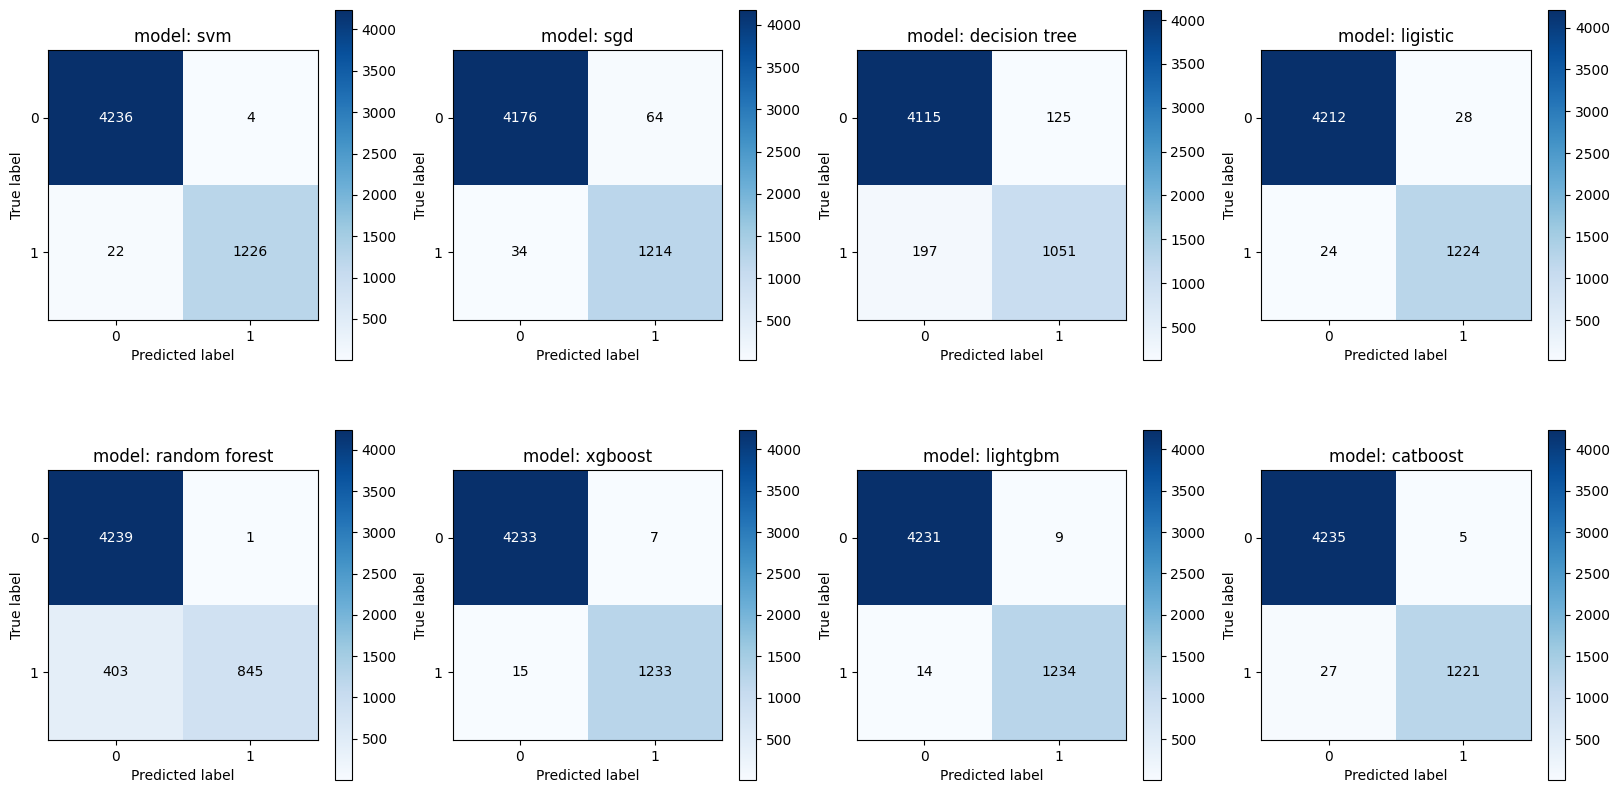

In [29]:
#Top 500 words without stopwords
CV = CountVectorizer(max_features=500, stop_words = 'english')
X = CV.fit_transform(df['text']).toarray()
print("Top words: ",CV.get_feature_names_out())

feat_500_without_stopwords = run_models(X, y)
# Quite high AUC drop on random forest

Top words:  ['able' 'able to' 'about' 'about the' 'according' 'according to' 'action'
 'action coding' 'actually' 'advantages' 'after' 'air' 'alien' 'aliens'
 'all' 'all of' 'all the' 'also' 'always' 'am' 'america' 'amount'
 'amount of' 'an' 'and' 'and it' 'and that' 'and the' 'animals' 'another'
 'any' 'are' 'are not' 'around' 'around the' 'article' 'as' 'as the' 'at'
 'at the' 'attention' 'author' 'away' 'back' 'bad' 'be' 'be able'
 'be able to' 'be the' 'because' 'because it' 'because of' 'because they'
 'become' 'been' 'before' 'being' 'believe' 'believe that' 'benefits'
 'best' 'better' 'big' 'bogota' 'both' 'but' 'but it' 'by' 'by the' 'can'
 'can be' 'can help' 'candidate' 'candidates' 'car' 'car free' 'car usage'
 'cars' 'cars are' 'cause' 'chance' 'change' 'cities' 'citizens' 'city'
 'classroom' 'clear' 'coding' 'coding system' 'college' 'college is'
 'come' 'computer' 'conclusion' 'conditions' 'could' 'could be'
 'countries' 'country' 'cowboy' 'cowboys' 'created' 'dangers' 'd

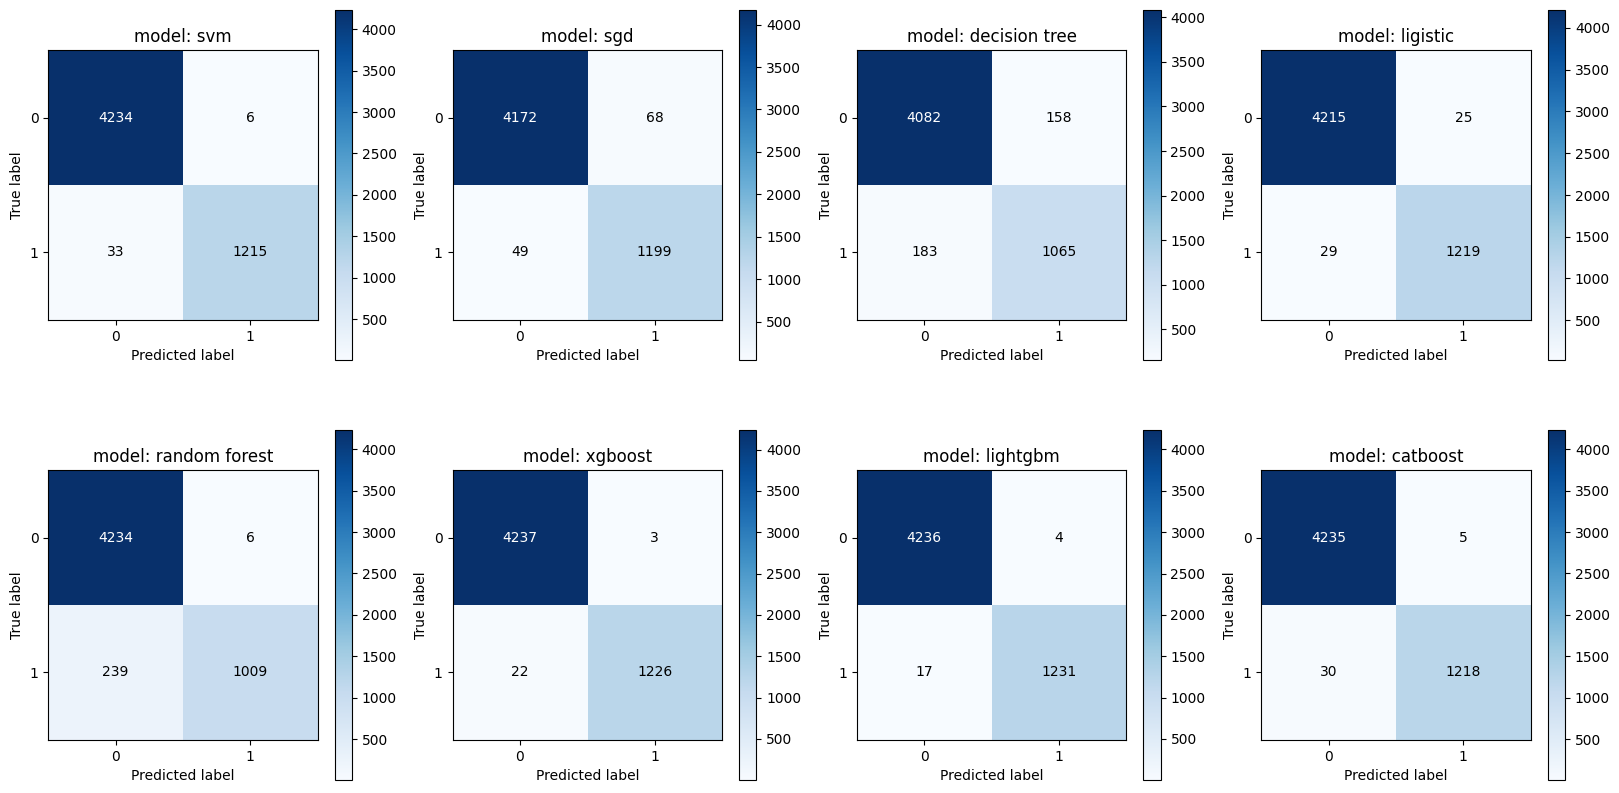

In [30]:
#Top 500 words without n_gram_range
CV = CountVectorizer(max_features=500,ngram_range=(1,3 ))
X = CV.fit_transform(df['text']).toarray()
print("Top words: ",CV.get_feature_names_out())

feat_500_ngram = run_models(X, y)

# Lets make submission stacking 8 models

In [31]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
df = pd.concat([train['text'], test['text']], axis=0)

In [32]:
vectorizer = TfidfVectorizer(ngram_range=(1,3 ), dtype=np.float32)
X = vectorizer.fit_transform(df)

In [ ]:
ensemble = VotingClassifier(estimators=models, voting='soft')
ensemble.fit(X[:train.shape[0]], train.label)

In [ ]:
preds_test = ensemble.predict_proba(X[train.shape[0]:])[:,1]

In [ ]:
pd.DataFrame({'id':test["id"],'generated':preds_test}).to_csv('submission.csv', index=False)